In [17]:
##### Load packages #####
library(tidyverse)
library(multcomp)
library(ggplot2)
library(car)
library(MASS)
library(stats)
library(sjPlot)
library(tidyverse)
library(lme4)
library(lmerTest)
library(LMERConvenienceFunctions)
library(multcomp)

In [18]:
# Load CSV
dir_name <- basename(getwd())
csv_file <- paste0(dir_name, ".csv")
graphdata <- read.csv(csv_file)

Trial_list <- c("Trial01", "Trial02", "Trial03", "Trial04", "Trial05", "Trial06", "Trial07", "Trial08", "Trial09", "Trial10")

#add column index
colnames(graphdata) <- paste0(sprintf("%02d", seq_along(colnames(graphdata))), " ", colnames(graphdata))

# Identify rows with NA (used to detect the gaps) in graphdata
gap_rows <- which(rowSums(is.na(graphdata)) == ncol(graphdata))

# Assign groups dynamically using Trial_list
graphdata$Group <- NA  # Initialize Group column

# Create a sequence of rows to handle gaps
gap_rows <- c(0, gap_rows, nrow(graphdata) + 1)  # Include start and end boundaries
current_trial_index <- 1  # Start from the first trial in Trial_list

# Assign groups dynamically
for (i in seq_along(gap_rows[-1])) {
  start <- gap_rows[i] + 1  # Start of the current block
  end <- gap_rows[i + 1] - 1  # End of the current block
  
  if (start <= end) {
    graphdata$Group[start:end] <- Trial_list[current_trial_index]
    current_trial_index <- current_trial_index + 1
    
    # Loop back to the start of Trial_list if necessary
    if (current_trial_index > length(Trial_list)) {
      current_trial_index <- 1
    }
  }
}

# Print the result to check
print(head(graphdata))

# Reshape graphdata to long format and keep Group in the third column
stacked_graphdata <- graphdata %>%
  pivot_longer(cols = -Group,  # Exclude the Group column from pivoting
               names_to = "ind",  # Column names will go to 'ind'
               values_to = "values") %>%  # Data will go to 'values'
  relocate(Group, .after = ind)  # Move Group column to the third position

# View the result
print(head(stacked_graphdata))

# Create the tallcsv dataframe with renamed columns
tallcsv <- stacked_graphdata %>%
  rename(
    VALUE = values,       
    Treatment = ind,      
    Trial = Group         
  ) %>%
  arrange(Trial, Treatment)  

# View the resulting dataframe
print(head(tallcsv))

#delete NA row
tallcsv2 <- tallcsv[!is.na(tallcsv$VALUE),]

#export
csv_file2 <- paste0(dir_name, "_tall.csv")
write.csv(tallcsv2,csv_file2, row.names = FALSE)

   01 wt_0h 02 wt_2h 03 arm1a.1_0h 04 arm1a.1_2h 05 arm1a.2_0h 06 arm1a.2_2h
1 0.7388397 23.59320            NA            NA     0.7508865      17.19160
2 1.0817247 23.92254            NA            NA     1.2541124      18.17184
3 1.2512181 23.92254            NA            NA     1.0619138      16.72150
4        NA       NA            NA            NA            NA            NA
5 1.0260000 19.71500         1.005        26.746            NA            NA
6 0.9770000 19.71500         0.977        24.782            NA            NA
  07 flg22_0h 08 flg22_2h   Group
1   1.0139595    94.15499 Trial01
2   0.9930925    96.13338 Trial01
3   0.9930925    97.47535 Trial01
4          NA          NA    <NA>
5   0.9530000    68.81100 Trial02
6   1.1020000    66.00800 Trial02
# A tibble: 6 × 3
  ind           Group   values
  <chr>         <chr>    <dbl>
1 01 wt_0h      Trial01  0.739
2 02 wt_2h      Trial01 23.6  
3 03 arm1a.1_0h Trial01 NA    
4 04 arm1a.1_2h Trial01 NA    
5 05 arm1a.2_0h Tri

# A tibble: 6 × 3
  Treatment Trial    VALUE
  <chr>     <chr>    <dbl>
1 01 wt_0h  Trial01  0.739
2 01 wt_0h  Trial01  1.08 
3 01 wt_0h  Trial01  1.25 
4 02 wt_2h  Trial01 23.6  
5 02 wt_2h  Trial01 23.9  
6 02 wt_2h  Trial01 23.9  


[1] 18 17

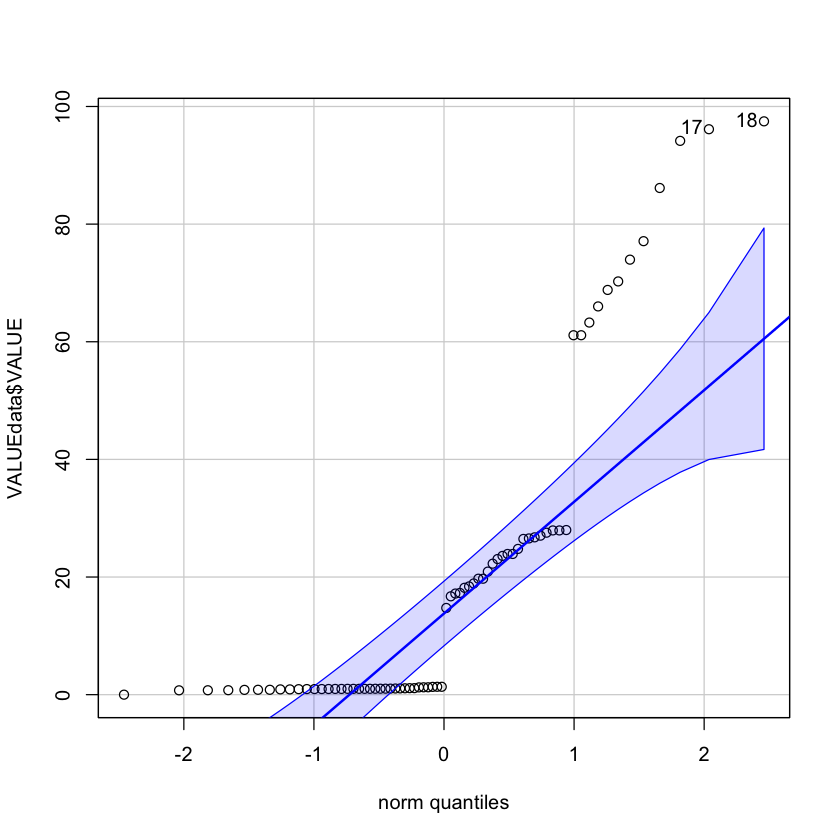

In [19]:
#VALUEdata=read.csv(choose.files())
VALUEdata <- tallcsv2
VALUEdata$VALUE <- as.numeric(as.character(VALUEdata$VALUE))
print(head(VALUEdata))
#Normal distribution
qqp(VALUEdata$VALUE, "norm")

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: VALUE ~ Treatment + (1 | Trial)
   Data: VALUEdata

     AIC      BIC   logLik deviance df.resid 
   479.4    502.2   -229.7    459.4       62 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.5726 -0.1433  0.0074  0.0557  3.5397 

Random effects:
 Groups   Name        Variance Std.Dev.
 Trial    (Intercept)  0.4327  0.6578  
 Residual             34.1855  5.8468  
Number of obs: 72, groups:  Trial, 4

Fixed effects:
                       Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)             0.92865    1.71958 48.24010   0.540    0.592    
Treatment02 wt_2h      22.35554    2.38696 66.92546   9.366 8.60e-14 ***
Treatment03 arm1a.1_0h  0.25023    2.93944 71.96088   0.085    0.932    
Treatment04 arm1a.1_2h 20.66423    2.93944 71.96088   7.030 9.75e-10 ***
Treatment05 arm1a.2_0h -0.07587    2.93944 71.96088  -0.026    0.979    
Treatment06 arm

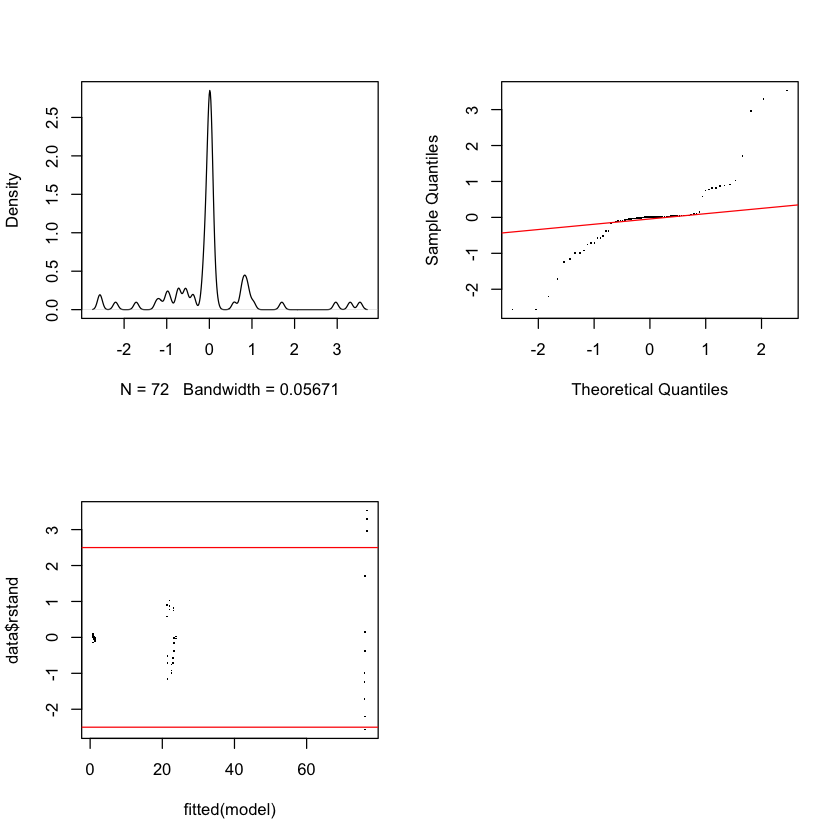

In [20]:
#set REML to FALSE if the data is normal, so we can use the maximum likelihood because the data are normal, we have similar sample sizes between effects, and we only have one random effect
VALUE.lmm<-lmer(VALUE ~ Treatment + (1|Trial), data = VALUEdata, REML = FALSE)
m<-lmer(VALUE ~ Treatment + (1|Trial), data = VALUEdata, REML = FALSE)
#the density plot should look roughly normal, centered on 0. In the quantile plot the black dots should roughly mirror the red line. And in the fitted residual plot most black dots should be between the red lines, with no obvious skew from left to right.
mcp.fnc(VALUE.lmm)
#If the above looks good, then we can get the model characteristics
summary(VALUE.lmm)
summary_name1 <- paste0("01.",dir_name, "_LMM_summary.txt")
capture.output(summary(VALUE.lmm), file = summary_name1)

In [21]:
#anova analysis of lmm
aov <- anova(m)
print(summary(aov))
# Save the summary to a text file
summary_name2 <- paste0("02.",dir_name, "_anova_summary.txt")
capture.output(summary(aov), file = summary_name2)

#Tukey's post-hoc, load library multcomp
tukey_result <- glht(m, linfct = mcp(Treatment = "Tukey"))
multcomps <- cld(tukey_result, alpha=0.1)
print(summary(tukey_result))
# Save the summary to a text file
summary_name3 <- paste0("03.",dir_name, "_multcomp_summary.txt")
capture.output(summary(tukey_result), file = summary_name3)

print(multcomps)
multcomp_name <- paste0("04.",dir_name, "_multcomp_letters.txt")
capture.output(print(multcomps), file = multcomp_name)

     Sum Sq         Mean Sq         NumDF       DenDF          F value     
 Min.   :51179   Min.   :7311   Min.   :7   Min.   :59.63   Min.   :213.9  
 1st Qu.:51179   1st Qu.:7311   1st Qu.:7   1st Qu.:59.63   1st Qu.:213.9  
 Median :51179   Median :7311   Median :7   Median :59.63   Median :213.9  
 Mean   :51179   Mean   :7311   Mean   :7   Mean   :59.63   Mean   :213.9  
 3rd Qu.:51179   3rd Qu.:7311   3rd Qu.:7   3rd Qu.:59.63   3rd Qu.:213.9  
 Max.   :51179   Max.   :7311   Max.   :7   Max.   :59.63   Max.   :213.9  
     Pr(>F)         
 Min.   :8.776e-40  
 1st Qu.:8.776e-40  
 Median :8.776e-40  
 Mean   :8.776e-40  
 3rd Qu.:8.776e-40  
 Max.   :8.776e-40  

	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = VALUE ~ Treatment + (1 | Trial), data = VALUEdata, 
    REML = FALSE)

Linear Hypotheses:
                                    Estimate Std. Error z value Pr(>|z|)    
02 wt_2h - 01 wt_0h == 0        